# Local Active Learning: Load location optimization

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

This file illustrates the Load Selection process in the Local Active Learning workflow. The loads are added to designs with existing load combinations $(M,V)$. The selection optimization depends on two parameters:
- Location of existing loads 
- Uncertainty / Prediction error of existing loads (according to their corresponding datapoints)

We formulate to objectives for the location selection of new loads:
1. The new load should be as far from all existing loads as possible
2. The new load should be as close to uncertain / high error loads as possible
This should ensure maximal exploration (objective 1) and maximal information gain (objective 2).

All considerations and steps of the load location optimization functions are illustrated in this file.

**Dependencies**: 
- `Datareader.py`
- `Settings.py`
- `DNN.py`
- `Saved Models\DNN_Model_Full_V2`

## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy

from scipy.interpolate import interp1d

import torch

ROOT = r"C:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks"
os.chdir(ROOT)

from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  C:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()

In [3]:
datareader = DataReader()

Root Directory set to:  C:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
extended_profiles_iter_3.csv
extenden_profiles_iter_1.csv
extenden_profiles_iter_2.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx


### Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


### Load Model

In [5]:
model = DNN()

model_name = "DNN_Model_Full_V2"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

print(model.data['data_reduction_factor'])

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization
0


In [6]:
features = model.features

## Get identical profiles for different load combinations

In [7]:
def find_similar_profiles(x_profile,log=True):
    # Get the fixed features (all except M_contribution and V_contribution)
    fixed_features = [feat for feat in model.features if feat not in ['M_contribution', 'V_contribution']]
    
    # Create a hashable key from the fixed features of x_profile
    x_profile_key = tuple(x_profile[fixed_features].values.astype(np.float32))[0]
    
    # Extract all profile data as a DataFrame for faster processing
    all_profiles_df = pd.DataFrame(model.x_data, columns=model.features)
    
    # Create mask for matching profiles
    mask = np.ones(len(all_profiles_df), dtype=bool)
    
    # Apply filter for each fixed feature
    for i, feature in enumerate(fixed_features):
        feature_idx = model.features.index(feature)
        mask &= (all_profiles_df.iloc[:, feature_idx] == x_profile_key[i])
    
    # Get indices of matching profiles
    profiles_similar = np.where(mask)[0].tolist()
    
    if log==True:
        print(f'{len(profiles_similar)} profiles found with the same fixed features')
    
    return profiles_similar

In [8]:
id = 346781

In [9]:
test_profile = df.iloc[id:id+1]
similar_profiles_id = find_similar_profiles(test_profile,log=True)

6 profiles found with the same fixed features


In [10]:
model_xdata_ids = model.data['data_indeces']

if np.all(np.array(model_xdata_ids) == np.arange(len(model.x_data))):
    print('Model data is not reduced')
else:
    print('DANGER')

Model data is not reduced


In [11]:
profiles_similar = df.iloc[similar_profiles_id]

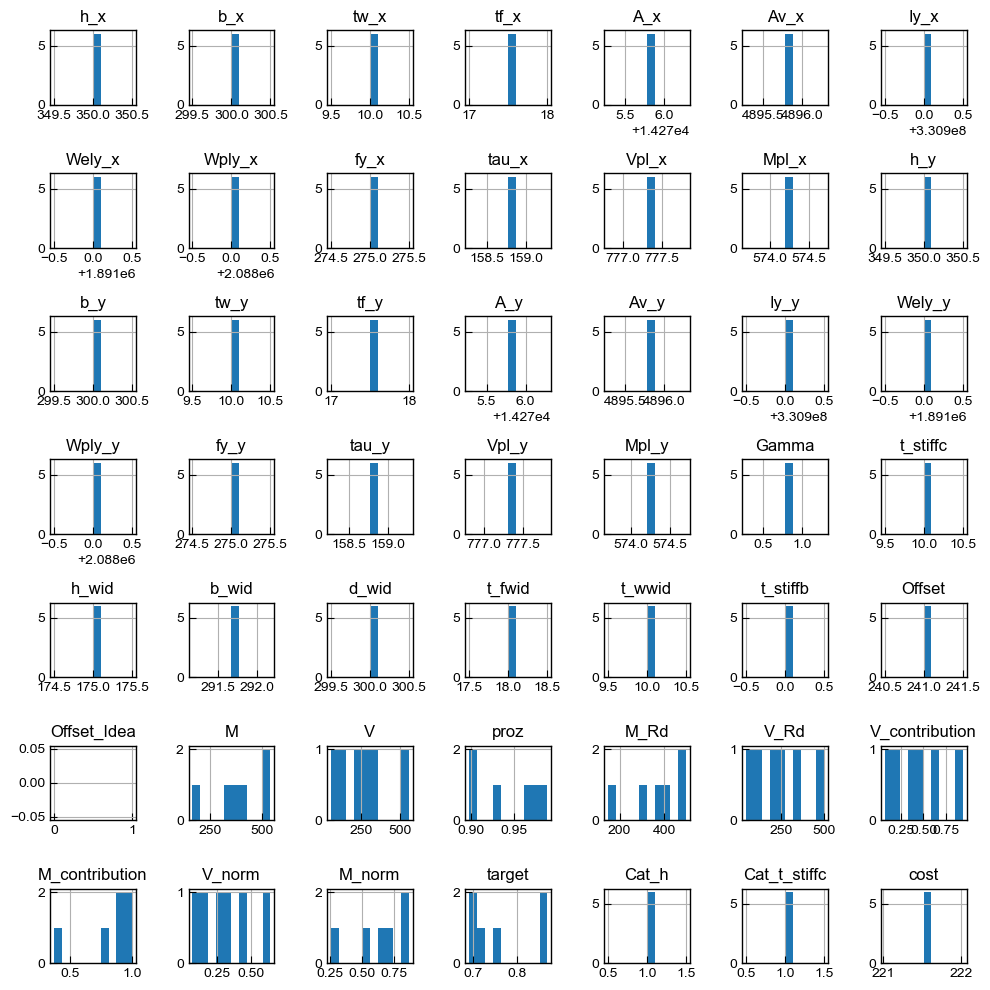

In [12]:
fig,ax = plt.subplots(figsize=(10, 10))
profiles_similar.hist(ax=ax)
plt.tight_layout()
plt.show()

$$V_{norm}= |\frac{V_{Rd}}{V_{pl,y}}|$$

$$M_{norm}= |\frac{M_{Rd}}{M_{pl,y}}|$$

$$\text{target}=\sqrt{V_{norm}^2+M_{norm}^2)}$$

$$M_{Rd}=\text{target}\cdot M_{pl,y} \cdot M_{contribution}$$
$$V_{Rd}=\text{target}\cdot V_{pl,y} \cdot V_{contribution}$$

## Get uncertainty of full data

#### Generate

In [13]:
mcd_mean_full, mcd_std_full, _ = model.mc_dropout_uncertainty(df_full, num_samples=200)
uncertainty_full = mcd_std_full / mcd_mean_full
np.save(r"Saved Variables\uncertainty_fulldf.npy", uncertainty_full)

KeyboardInterrupt: 

#### Load

In [13]:
uncertainty_full = np.load(r"Saved Variables\uncertainty_fulldf.npy").flatten()

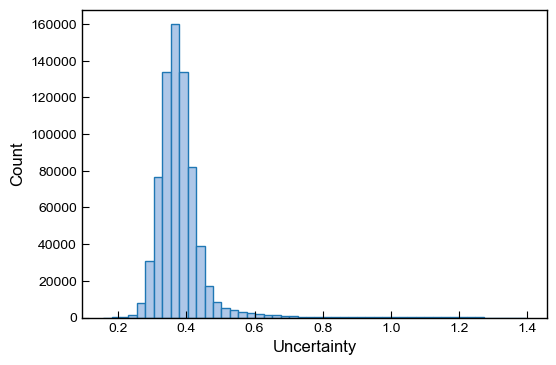

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.hist(uncertainty_full, bins=50, 
         facecolor=plot_params.morecolors[1],
         edgecolor=plot_params.morecolors[0],)

plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.show()

## Visualize Objectives

In [14]:
mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(profiles_similar, num_samples=1000)
uncertainty = mcd_std / mcd_mean

Make the uncertainty metric more readable by setting it into the context of all the previously calculated uncertainty and getting the confidence (percentage of smaller values). With this the new uncertainty metric is between 0-100% (or slightly higher).

In [15]:
relative_uncertainty = np.array([np.sum(uncertainty_full < value) for value in uncertainty]) / len(uncertainty_full)

For identical features multiple load combinations exist. Get the uncertainty for all of them to get an idea where the model needs more data. Two objectives can be considered when adding new data:

- Fill in the gaps: Add data in larger gaps to achieve an evenly spread out load combination distribution.

- Close to uncertainty: Add data close load combinations where the uncertainty is high.

Both objectives can be considered independently or in a multi-objective approach.

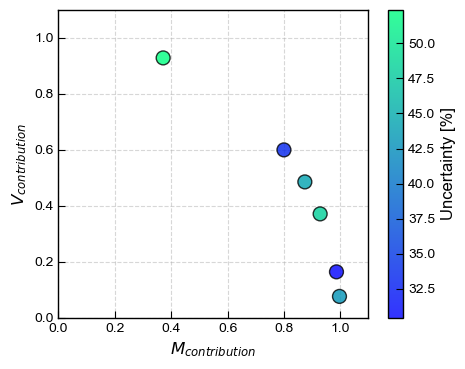

In [26]:
fig, ax = plt.subplots(figsize=(5,4))

plt.scatter(profiles_similar['M_contribution'],
            profiles_similar['V_contribution'],
            c=relative_uncertainty*100,
            cmap='winter',
            alpha=0.8,
            edgecolor='black',
            s=100,
            label='Existing Data',
            zorder=2)

plt.colorbar(label='Uncertainty [%]')
plt.xlabel(r'$M_{contribution}$')
plt.ylabel(r'$V_{contribution}$')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.5,
         zorder=0)

plt.show()

In [27]:
n_similar = len(similar_profiles_id)

norm = mcolors.Normalize(vmin=min(uncertainty), vmax=max(uncertainty))
cmap = plt.cm.viridis

colors = [cmap(norm(value)) for value in uncertainty]

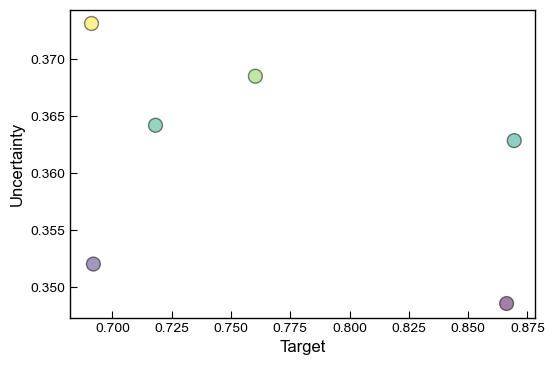

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(profiles_similar['target'],uncertainty,
            c=colors,
            alpha=0.5,
            edgecolor='k',
            s=100)

plt.xlabel('Target')
plt.ylabel('Uncertainty')
plt.show()

## Develop objectives

**Exploration** (filling gaps)

**Exploitation** (reducing uncertainty)

In [29]:
angles = np.arcsin(profiles_similar['V_contribution'].values) / (np.pi/2)

# Normalize between 0 and 1
uncertainty_normalized = (uncertainty - np.min(uncertainty)) / (np.max(uncertainty) - np.min(uncertainty))

# Sort
sorted_indices = np.argsort(angles)
angles_sorted = angles[sorted_indices]
uncertainty_sorted = uncertainty_normalized[sorted_indices]

# Add boundary values
if 0 not in angles_sorted:
    angles_sorted = np.insert(angles_sorted, 0, 0)
    uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

if 1 not in angles_sorted:
    angles_sorted = np.append(angles_sorted, 1)
    uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

In [30]:
interpolation_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))

Value to scale minimum distance objective

In [31]:
angles_gaps = np.diff(angles_sorted)
uncertainty_gaps = np.diff(uncertainty_sorted)

slope = np.max(uncertainty_normalized) / np.mean(angles_gaps)

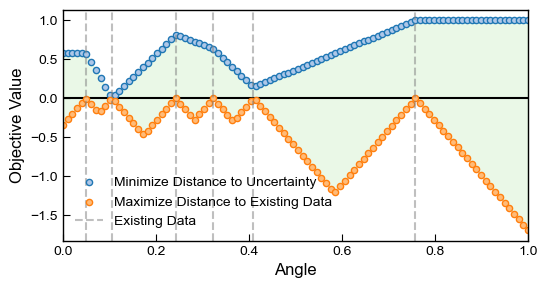

In [33]:
x = np.linspace(0, 1, 100)

uncertainty_interpolated = interpolation_func(x)
distance_to_existing = -np.array([min_distance(xi, angles) for xi in x])*slope

fig, ax = plt.subplots(figsize=(6, 3))
plt.scatter(x,uncertainty_interpolated,
            facecolor=plot_params.morecolors[1], 
            edgecolor=plot_params.morecolors[0],
            label='Minimize Distance to Uncertainty',
            s=20)
plt.scatter(x,distance_to_existing,
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            label='Maximize Distance to Existing Data',
            s=20)

plt.fill_between(x,distance_to_existing, uncertainty_interpolated,
                 alpha=0.2,
                 zorder=0,
                 color=plot_params.morecolors[5],)

for i, angle in enumerate(angles):
    label = "Existing Data" if i == 0 else None
    plt.axvline(angle, 
                color='gray', 
                linestyle='--', 
                label=label,
                alpha=0.5)

plt.axhline(0, color='black',zorder=0)
plt.xlim(0, 1)
plt.legend()
plt.xlabel('Angle')
plt.ylabel('Objective Value')
plt.show()

CHANGE: Objective calculate with Objective Distance * Objective Uncertainty (instead of difference). This eliminates the need to scale the objectives

In [34]:
def find_optimal_location_old(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    #angles_sorted, uncertainty_sorted = np.sort(angles), np.sort(uncertainty_normalized)

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    angles_gaps = np.diff(angles_sorted)
    slope = np.max(uncertainty_normalized) / np.mean(angles_gaps)
    
    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_to_existing = -np.array([min_distance(xi, angles) for xi in x])*slope
    objective = uncertainty_interpolated - distance_to_existing

    return x[np.argmax(objective)]

In [35]:
def find_optimal_location(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    #angles_sorted, uncertainty_sorted = np.sort(angles), np.sort(uncertainty_normalized)

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_penalty = np.array([min_distance(xi, angles[sorted_indices]) for xi in x])
    objective = uncertainty_interpolated * distance_penalty

    return x[np.argmax(objective)], uncertainty_interpolated[np.argmax(objective)] * (uncertainty.max() - uncertainty.min()) + uncertainty.min()

In [36]:
ratio, _ = find_optimal_location(profiles_similar['V_contribution'].values, uncertainty)

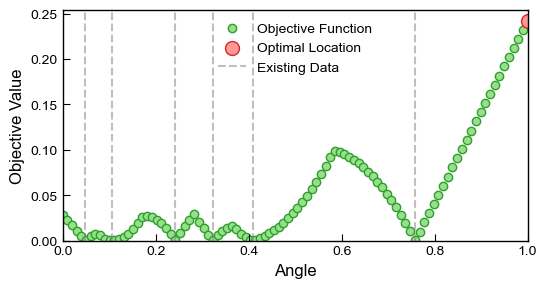

In [37]:
uncertainty_interpolated = interpolation_func(x)
distance_to_existing = np.array([min_distance(xi, angles) for xi in x])
objective = uncertainty_interpolated * distance_to_existing
x_max = x[np.argmax(objective)]

fig, ax = plt.subplots(figsize=(6, 3))

plt.scatter(x,objective,
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            label='Objective Function')
plt.scatter(x_max, np.max(objective),
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            label='Optimal Location',
            s=100)

for i, angle in enumerate(angles):
    label = "Existing Data" if i == 0 else None
    plt.axvline(angle, 
                color='gray', 
                linestyle='--', 
                label=label,
                alpha=0.5)

plt.legend()
plt.xlim(0, 1)
plt.ylim(0,None)
plt.ylabel('Objective Value')
plt.xlabel('Angle')
plt.show()

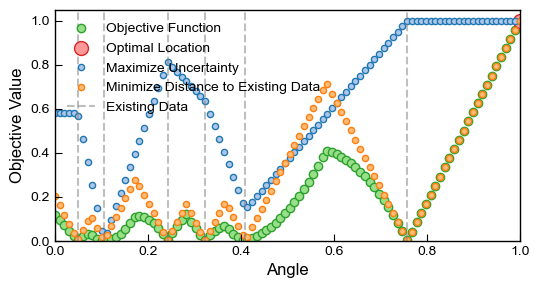

In [38]:
uncertainty_interpolated = interpolation_func(x)
distance_to_existing = np.array([min_distance(xi, angles) for xi in x])
objective = uncertainty_interpolated * distance_to_existing
x_max = x[np.argmax(objective)]

fig, ax = plt.subplots(figsize=(6, 3))

plt.scatter(x,objective/np.max(objective),
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            label='Objective Function')
plt.scatter(x_max, np.max(objective)/np.max(objective),
            facecolor=plot_params.morecolors[7],
            edgecolor=plot_params.morecolors[6],
            label='Optimal Location',
            s=100)

plt.scatter(x,uncertainty_interpolated/np.max(uncertainty_interpolated),
            facecolor=plot_params.morecolors[1], 
            edgecolor=plot_params.morecolors[0],
            label='Maximize Uncertainty',
            s=20)

plt.scatter(x,distance_to_existing/np.max(distance_to_existing),
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            label='Minimize Distance to Existing Data',
            s=20)

for i, angle in enumerate(angles):
    label = "Existing Data" if i == 0 else None
    plt.axvline(angle, 
                color='gray', 
                linestyle='--', 
                label=label,
                alpha=0.5)

plt.legend()
plt.xlim(0, 1)
plt.ylim(0,None)
plt.ylabel('Objective Value')
plt.xlabel('Angle')
plt.show()

In [39]:
M_contribution = np.cos(ratio * (np.pi / 2))
V_contribution = np.sin(ratio * (np.pi / 2))

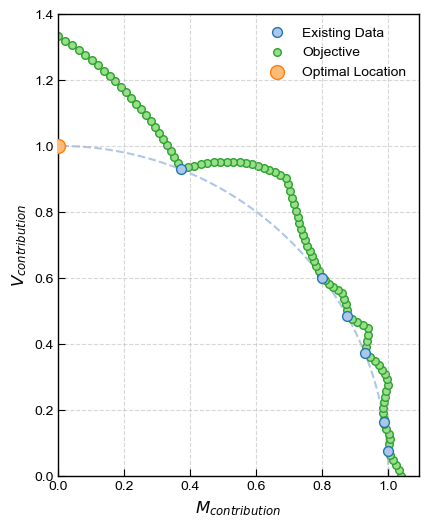

In [47]:
x_angles = x*np.pi/2
objective_circle = np.array([np.cos(x_angles)*(1+objective/np.max(objective)/3), np.sin(x_angles)*(1+objective/np.max(objective)/3)]).T

fig, ax = plt.subplots(figsize=(6, 6))

circle = np.array([np.cos(x_angles), np.sin(x_angles)]).T

plt.scatter(profiles_similar['M_contribution'],
            profiles_similar['V_contribution'],
            facecolor=plot_params.morecolors[1],
            edgecolors=plot_params.morecolors[0],
            zorder=2,
            label='Existing Data',
            s=50)
plt.plot(circle[:, 0], circle[:, 1], 
         color=plot_params.morecolors[1], 
         linestyle='--', 
         zorder=0)

plt.scatter(objective_circle[:, 0],
            objective_circle[:, 1],
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            zorder=1,
            label='Objective',
            s=30)

plt.scatter(M_contribution, V_contribution,
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            zorder=3,
            label='Optimal Location',
            s=100)

plt.plot(objective_circle[:, 0], objective_circle[:, 1],
         color=plot_params.morecolors[5],
         zorder=0)

plt.xlim(0,None)
plt.ylim(0,None)
plt.grid(True, linestyle='--', alpha=0.5, zorder=0)
plt.legend()
ax.set_aspect('equal')
plt.xlabel(r'$M_{contribution}$')
plt.ylabel(r'$V_{contribution}$')
plt.show()

## Add Multiple Loads at once

In [176]:
base_profile = df.iloc[id:id+1].copy()

In [177]:
existing_profiles = profiles_similar.copy()
mcd_mean_existing, mcd_std_existing,_ = model.mc_dropout_uncertainty(existing_profiles, num_samples=200)
uncertainty_existing = mcd_std_existing.flatten() / mcd_mean_existing.flatten()
uncertainty = uncertainty_existing.copy()

In [178]:
def get_MV_contribution(ratio):
    M_contribution = np.cos(ratio * (np.pi / 2))
    V_contribution = np.sin(ratio * (np.pi / 2))
    M_contribution = round(M_contribution, 12)
    V_contribution = round(V_contribution, 12)
    return M_contribution, V_contribution

In [179]:
add_n_points = 3

for i in range(add_n_points):
    V_contribution = existing_profiles['V_contribution'].values

    ratio,closest_uncertainty = find_optimal_location(V_contribution, uncertainty_existing)
    M_contribution_new, V_contribution_new = get_MV_contribution(ratio)

    new_profile = base_profile.copy()
    new_profile['M_contribution'] = M_contribution_new
    new_profile['V_contribution'] = V_contribution_new

    existing_profiles = pd.concat([existing_profiles, new_profile], ignore_index=True)
    uncertainty_existing = np.append(uncertainty_existing, closest_uncertainty)

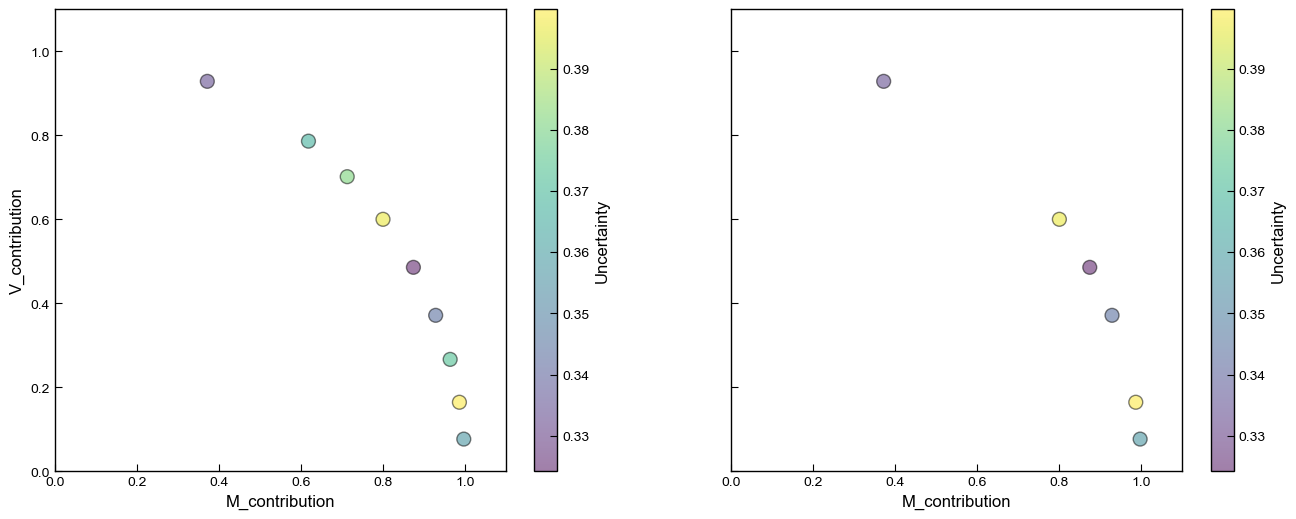

In [180]:
fig, axs = plt.subplots(1,2,figsize=(16, 6),sharex=True, sharey=True)

sc1 = axs[0].scatter(existing_profiles['M_contribution'],
            existing_profiles['V_contribution'],
            c=uncertainty_existing,
            cmap='viridis',
            alpha=0.5,
            edgecolor='k',
            s=100)

sc2 = axs[1].scatter(profiles_similar['M_contribution'],
            profiles_similar['V_contribution'],
            c=uncertainty,
            cmap='viridis',
            alpha=0.5,
            edgecolor='k',
            s=100)

plt.colorbar(sc1, ax=axs[0], label='Uncertainty')
plt.colorbar(sc2, ax=axs[1], label='Uncertainty')
axs[0].set_xlabel('M_contribution')
axs[0].set_ylabel('V_contribution')
axs[1].set_xlabel('M_contribution')
axs[0].set_xlim(0, 1.1)
axs[0].set_ylim(0, 1.1)

axs[1].set_xlim(0, 1.1)
axs[1].set_ylim(0, 1.1)

plt.show()